<a href="https://colab.research.google.com/github/Mal-Lem/Analyse-temporelle-et-d-tection-d-anomalies-sur-le-march-immobilier/blob/main/analysis_notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse temporelle et détection d’anomalies sur le marché immobilier
Ce notebook guide l'analyse de la base de transactions immobilières (2018–2022) en mobilisant pandas, NumPy, Matplotlib et Seaborn.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('transactions_immobilires_2018_2022.csv', parse_dates=['transaction_date'])
df.head()

,transaction_date,price
0,2018-01-01,184530.883119
1,2018-01-01,237974.699627
2,2018-01-01,302610.494412
3,2018-01-01,179277.128560
4,2018-01-02,217134.748429


## 1. Préparation des données
**Questions :**
1. Y a-t-il des dates manquantes ou des doublons ?
2. Comment se répartissent les transactions selon le jour de la semaine et le mois ?

**Étapes :**
- Vérification des valeurs manquantes / doublons
- Création des colonnes dérivées (`year`, `month`, `day_of_week`, composants saisonniers)


In [47]:
# 1.1 Vérification des données manquantes et doublons
df.isnull().sum()
df.duplicated().sum()

np.int64(0)

*  Parce que les mois sont cycliques : après décembre (12), on revient à janvier (1).
Si tu faisais juste un encodage avec 1, 2, ..., 12, un modèle ne comprendrait pas que janvier et décembre sont "proches".

*  Ces deux composantes (sin et cos) permettent de projeter les mois sur un cercle 🟢, pour que la distance entre mois reflète leur proximité dans l'année, de manière continue

In [48]:
# 1.2 Création des colonnes dérivées
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df['day_of_week'] = df['transaction_date'].dt.day_name()
df['month_sin'] = np.sin(2 * np.pi * (df['month']-1)/12)
df['month_cos'] = np.cos(2 * np.pi * (df['month']-1)/12)
df.head()

,transaction_date,price,year,month,day_of_week,month_sin,month_cos
0,2018-01-01,184530.883119,2018,1,Monday,0.0,1.0
1,2018-01-01,237974.699627,2018,1,Monday,0.0,1.0
2,2018-01-01,302610.494412,2018,1,Monday,0.0,1.0
3,2018-01-01,179277.128560,2018,1,Monday,0.0,1.0
4,2018-01-02,217134.748429,2018,1,Tuesday,0.0,1.0


## 2. Analyse temporelle
**Questions :**
1. Quelle est la tendance générale du prix moyen annuel ?
2. Existe-t-il une saisonnalité mensuelle marquée ?
3. Comment les moyennes mobiles à 3 et 12 mois lissent-elles ces fluctuations ?

**Étapes :**
- Agrégation mensuelle et annuelle (`resample`, `groupby`)
- Décomposition STL (statsmodels)  (`rolling`)
- Visualisation des séries et boxplots mensuels


In [49]:
""" 2.1 Agrégation mensuelle et annuelle
"""
monthly = df.set_index('transaction_date').resample('ME')['price'].agg(['mean','std','count'])
annual= df.set_index('transaction_date').resample('YE')['price'].agg(['mean','std','count'])
monthly.head(),annual.head()

(                           mean           std  count
 transaction_date                                    
 2018-01-31        201292.822990  25979.448830     79
 2018-02-28        219596.331801  30171.855265     88
 2018-03-31        243448.486455  31046.343453     86
 2018-04-30        256889.161077  35500.054170     88
 2018-05-31        246622.090179  19815.605862    102,
                            mean           std  count
 transaction_date                                    
 2018-12-31        200156.578941  44846.957791   1056
 2019-12-31        200953.176281  43186.443518   1076
 2020-12-31        201266.270527  43551.276699   1096
 2021-12-31        201012.953087  42600.551543   1084
 2022-12-31        198184.737037  42766.807301   1100)

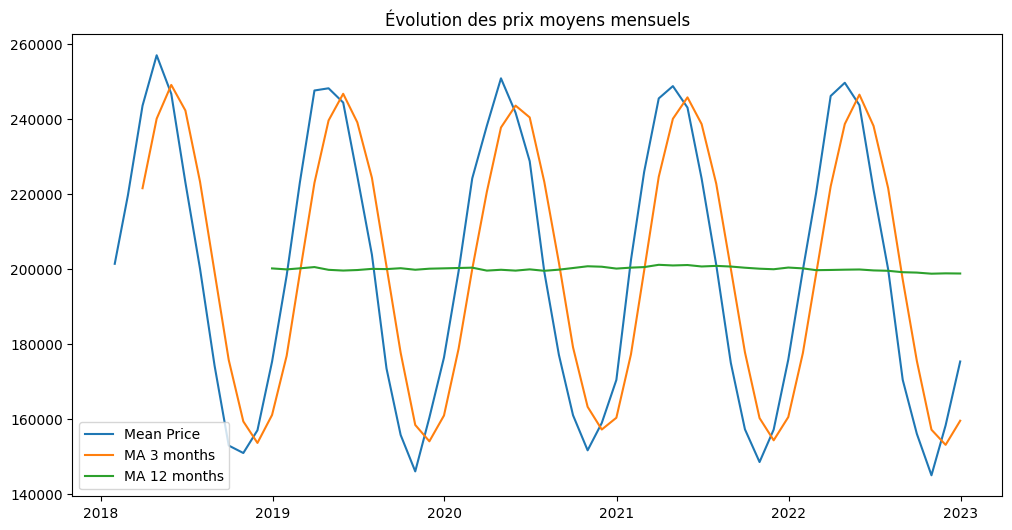

In [50]:
# 2.2 Moyennes mobiles
monthly['MA_3']= monthly['mean'].rolling(window=3).mean()
monthly['MA_12']= monthly['mean'].rolling(window=12).mean()

# 2.3 Visualisation
plt.figure(figsize=(12,6))
plt.plot(monthly.index, monthly['mean'], label='Mean Price')
plt.plot(monthly.index, monthly['MA_3'], label='MA 3 months')
plt.plot(monthly.index, monthly['MA_12'], label='MA 12 months')
plt.legend()
plt.title('Évolution des prix moyens mensuels')
plt.show()

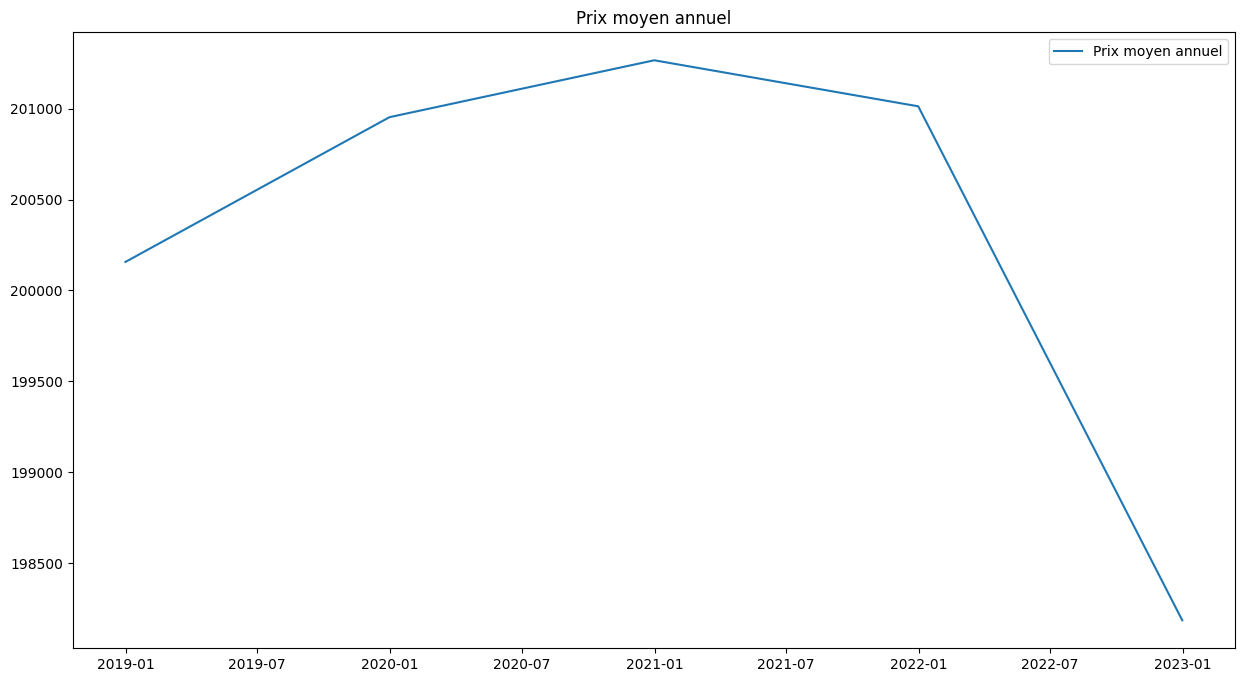

In [51]:
plt.figure(figsize=(15, 8))
plt.plot(annual.index,annual['mean'], label='Prix moyen annuel')
plt.title('Prix moyen annuel')
plt.legend()
plt.show()

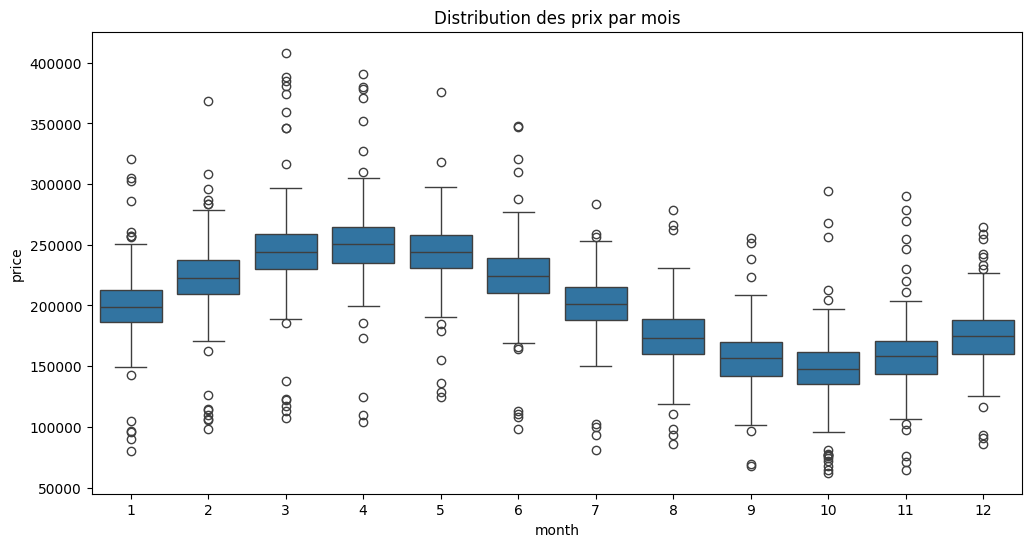

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='price', data=df)
plt.title('Distribution des prix par mois')
plt.show()

## 3. Détection d’anomalies
**Questions :**
1. Quels critères (Z-score, IQR) repèrent le mieux les transactions extrêmes ?
2. Quelles catégories (mois, quartile de prix) concentrent le plus d’anomalies ?

**Étapes :**
- Calcul des Z-scores et IQR via NumPy
- Ajout de la colonne `is_outlier`
- Visualisation des anomalies


## Calcul des Z‑scores

### Définition

Le **Z‑score** (ou score standardisé) d’une valeur $x_i$ dans un ensemble de données est le nombre d’écarts‑types ($\sigma$) qu’elle se situe au‑dessus ou en‑dessous de la moyenne ($\mu$) de cet ensemble. Mathématiquement :
$$
Z_i = \frac{x_i - \mu}{\sigma}
$$
- Si $Z_i = 0$, alors $x_i = \mu$.  
- Si $Z_i > 0$, alors $x_i$ est au‑dessus de la moyenne.  
- Si $Z_i < 0$, alors $x_i$ est en‑dessous de la moyenne.  

---

### Interprétation

- Un Z‑score compris entre $-1$ et $+1$ signifie que la valeur est à l’intérieur d’un écart‑type de la moyenne (environ 68 % des données si la distribution est normale).  
- Un Z‑score au‑delà de $\pm 2$ ou $\pm 3$ indique une valeur relativement extrême (outlier) dans une distribution normale théorique.  

---

### Calcul théorique

1. **Calculer la moyenne**

   $$
   \mu = \frac{1}{n} \sum_{i=1}^{n} x_i
   $$

3. **Calculer l’écart‑type**  
   $$
   \sigma = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}
    $$
   > *(pour un **échantillon**, on utiliserait $\frac{1}{n-1}$ au dénominateur)*

4. **Appliquer la formule du Z‑score**  
   Pour chaque $x_i$ :
   $$
   Z_i = \frac{x_i - \mu}{\sigma}
   $$

---

## Calcul de l’Interquartile Range (IQR)

### Définition

L’**Interquartile Range** (IQR) mesure l’étendue du milieu de la distribution :

$$
\mathrm{IQR} = Q_3 - Q_1
$$

où :

- $Q_1$ est le premier quartile (valeur sous laquelle se trouvent 25 % des observations).  
- $Q_3$ est le troisième quartile (valeur sous laquelle se trouvent 75 % des observations).  

---

### Interprétation

- L’IQR représente la dispersion “centrale” des données, moins sensible aux valeurs extrêmes que l’écart‑type.  
- On définit parfois comme **outliers** les points $x_i$ tels que :  
  $$
  x_i < Q_1 - 1.5 \times \mathrm{IQR}
  \quad\text{ou}\quad
  x_i > Q_3 + 1.5 \times \mathrm{IQR}
  $$

---

### Calcul théorique

1. **Trier les données** en ordre croissant.  
2. **Déterminer la position de $Q_1$**  
   $$
   \text{indice}_{Q_1} = \frac{n + 1}{4}
    $$
   et interpoler si nécessaire.  
3. **Déterminer la position de $Q_3$**  
  $$
   \text{indice}_{Q_3} = \frac{3 \times (n + 1)}{4}
    $$
   et interpoler si nécessaire.  
4. **Calculer l’IQR**  
  $$
   \mathrm{IQR} = Q_3 - Q_1
   $$


In [53]:
# 3.1 Z-score
import numpy as np
mean = df['price'].mean()
std = df['price'].std()
df['z_score'] = (df['price'] - mean) / std
df['outlier_z'] = df['z_score'].abs() > 3

# 3.2 IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df['outlier_iqr'] = (df['price'] < Q1 - 1.5 * IQR) | (df['price'] > Q3 + 1.5 * IQR)
df['is_outlier'] = df['outlier_z'] | df['outlier_iqr']

df[['price','z_score','outlier_z','outlier_iqr','is_outlier']].head()

,price,z_score,outlier_z,outlier_iqr,is_outlier
0,184530.883119,-0.363686,False,False,False
1,237974.699627,0.868085,False,False,False
2,302610.494412,2.357809,False,False,False
3,179277.128560,-0.484775,False,False,False
4,217134.748429,0.387766,False,False,False


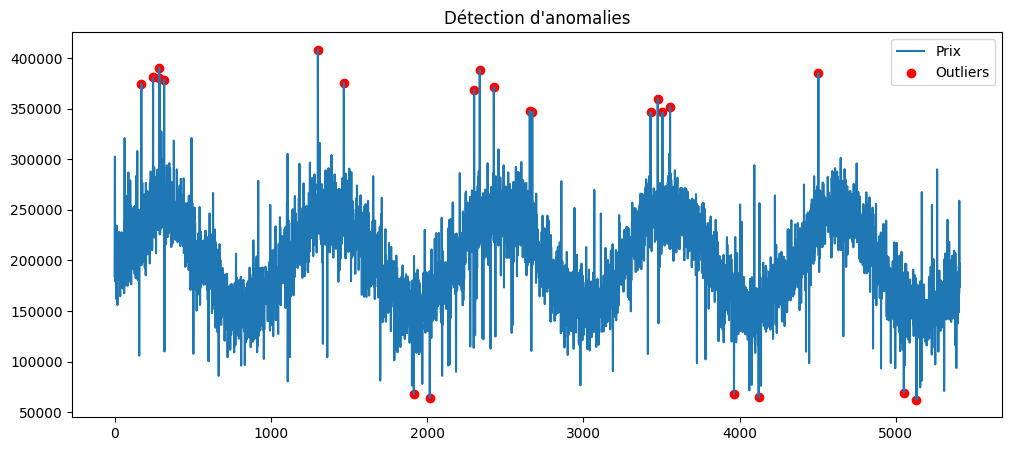

In [54]:
#3.3 visualisation des annomalies
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['price'], label='Prix')
plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']]['price'], color='red', label='Outliers')
plt.title('Détection d\'anomalies')
plt.legend()
plt.show()

## 4. Visualisations principales
**Questions :**
1. Comment la distribution des prix évolue-t-elle selon le mois ?
2. Les anomalies sont-elles corrélées à la saison ou au volume de transactions ?

**Étapes :**
- Boxplots mensuels et violin + swarm
- Scatter temps vs prix coloré par anomalie


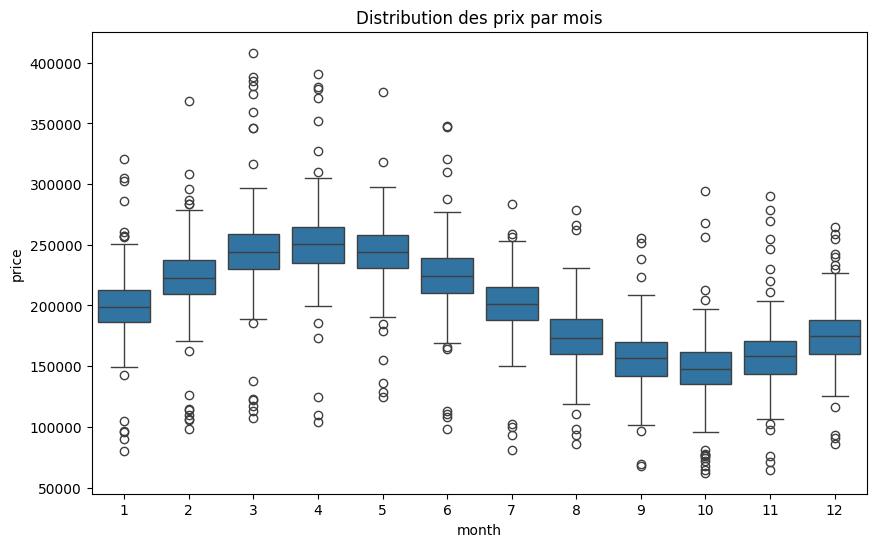

In [55]:
# Boxplot mensuel
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='price', data=df)
plt.title('Distribution des prix par mois')
plt.show()

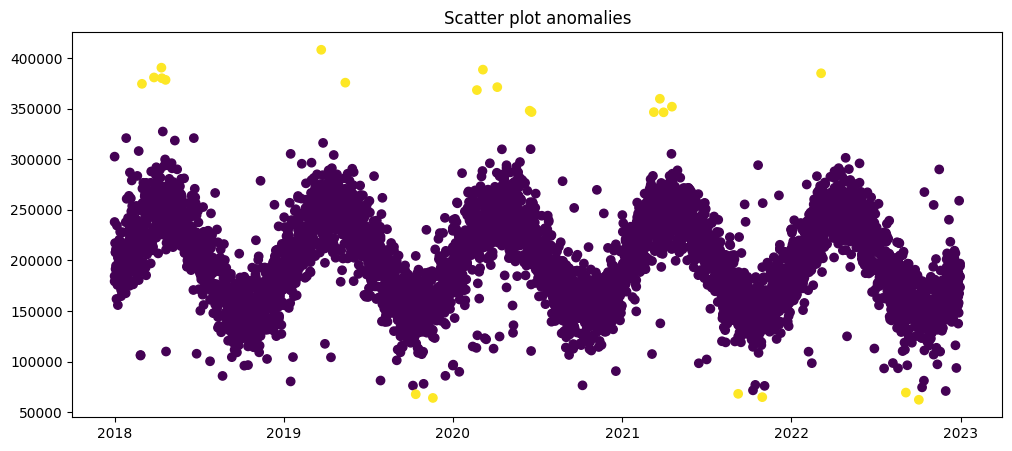

In [57]:

plt.figure(figsize=(12, 5))
plt.scatter(df['transaction_date'], df['price'], c=df['is_outlier'], label='Outliers')
plt.title('Scatter plot anomalies')
plt.show()

In [64]:
!pip install streamlit pyngrok

In [65]:
code = '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import streamlit as st

# Charger les données (adapter le chemin si besoin)
df = pd.read_csv("transactions_immobilires_2018_2022.csv", parse_dates=["transaction_date"])

# Préparation des données
df.dropna(subset=["transaction_date"], inplace=True)
df["year"] = df["transaction_date"].dt.year
df["month"] = df["transaction_date"].dt.month
df["day_of_week"] = df["transaction_date"].dt.day_name()

# Composantes cycliques
months_rad = 2 * np.pi * df["month"] / 12
df["month_sin"] = np.sin(months_rad)
df["month_cos"] = np.cos(months_rad)

# Interface Streamlit
st.title("Dashboard - Transactions Immobilières 2018-2022")

# Filtrage par année
years = df["year"].sort_values().unique()
selected_years = st.multiselect("Sélectionnez les années :", options=years, default=list(years))
filtered_df = df[df["year"].isin(selected_years)]

# 1. Volume de transactions par mois
monthly_counts = filtered_df.groupby(["year", "month"]).size().reset_index(name="transactions")
st.subheader("Volume mensuel des transactions")
fig1 = px.line(monthly_counts, x="month", y="transactions", color="year", markers=True)
st.plotly_chart(fig1)

# 2. Répartition par jour de la semaine
weekday_counts = filtered_df["day_of_week"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
st.subheader("Transactions par jour de la semaine")
st.bar_chart(weekday_counts)

# 3. Détection d'anomalies (valeurs très hautes/basses par mois)
st.subheader("Détection d'anomalies")
mean_per_month = monthly_counts.groupby("month")["transactions"].mean()
std_per_month = monthly_counts.groupby("month")["transactions"].std()
monthly_counts["z_score"] = monthly_counts.apply(
    lambda row: (row["transactions"] - mean_per_month.loc[row["month"]]) / std_per_month.loc[row["month"]], axis=1)
anomalies = monthly_counts[np.abs(monthly_counts["z_score"]) > 2]
fig2 = px.scatter(monthly_counts, x="month", y="transactions", color="year", hover_data=["z_score"])
fig2.add_scatter(x=anomalies["month"], y=anomalies["transactions"], mode="markers", marker=dict(color="red", size=10), name="Anomalies")
st.plotly_chart(fig2)

# Footer
st.markdown("---")
st.caption("Analyse temporelle des transactions immobilières - Données 2018 à 2022")

'''
with open("dashboard.py", "w") as f:
    f.write(code)


In [66]:
!ngrok config add-authtoken 2vtkPQQP2rhdfsXt4Rf5nZSCbxv_613JnY64XgrFM5F8fHfwn

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [68]:
from pyngrok import ngrok
import os

public_url = ngrok.connect("http://localhost:8501")
os.system("streamlit run dashboard.py &")
print("🚀 Ton dashboard est ici 👉", public_url)

🚀 Ton dashboard est ici 👉 NgrokTunnel: "https://536a-34-106-88-226.ngrok-free.app" -> "http://localhost:8501"
